# XGBoost - WithDask

**Using Optuna for hyper-parameter search  to predict TPSA from Pharmacophores**

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# Models
import os, sys
import math
import pickle
import itertools
import copy 
import joblib
# from multiprocessing import Pool, process
from datetime import datetime
from collections.abc import Iterator

import numpy as np
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

import pandas as pd
pd.options.display.width = 170

import scipy.stats as sps 

import matplotlib.pyplot as plt

from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)

# from utils import *
from utils_ml import model_selection


#### xgboost and dask imports 

In [3]:
import joblib
# from dask_cuda import LocalCUDACluster
# from sklearn.model_selection import GridSearchCV
import optuna

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask_ml.model_selection as dcv
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV, IncrementalSearchCV, HyperbandSearchCV
from dask_ml.metrics import mean_squared_error, r2_score, mean_squared_log_error
import sklearn.metrics as skm

/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
# os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# time.strftime(' %x%X')
# datetime.now().strftime('%X.%f')
# time.strftime('%X %x %Z')
print(datetime.now().strftime('%D-%X.%f'))
time_fmt = '%Y-%M-%d %H:%m:%S.%f'
print(datetime.now().strftime(time_fmt))

01/25/24-14:48:35.241539
2024-48-25 14:01:35.241743


In [7]:
import logging
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
logging.getLogger("imported_module").setLevel(logging.CRITICAL)
logging.info(f" 1/7- engine connected")
logging.warning(f" 1/7- engine connected")
logging.error(f" 1/7- engine connected")
logging.critical(f" 1/7- engine connected")

2024-01-25 14:48:38,000 - INFO: -  1/7- engine connected
2024-01-25 14:48:38,001 - WARNING: -  1/7- engine connected
2024-01-25 14:48:38,002 - ERROR: -  1/7- engine connected
2024-01-25 14:48:38,003 - CRITICAL: -  1/7- engine connected


In [9]:
# print(logging.NOTSET, logging.DEBUG,  logging.INFO, logging.WARN, logging.WARNING, logging.ERROR, logging.CRITICAL,  logging.FATAL)
# xgb.__version__

#### Datasets

In [10]:
prefix = '' ### Target-2' , 'MOA'
input_path ="./input/"
output_path ="./output_11102023/"
prefix_lc = prefix.lower().replace('-', '_')

CompoundExtendedMetadata2SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_2samples.csv"
CompoundProfiles2SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_2samples.csv"
CompoundExtendedMetadataSampleFile  = f"{output_path}{prefix_lc}compound_extended_metadata_samples.csv"
featureSelectionFile                = f"./metadata/feature_selection_columns.pkl"
trainingMetrics                     = f"{output_path}{prefix_lc}training_metrics.pkl"
print()
print(f" Compound Extended Metadata 2 SampleFile  : {CompoundExtendedMetadata2SampleFile }")
print(f" Compound Profiles 2 Samples File CSV     : {CompoundProfiles2SampleFileCSV}")
print(f" ")
print(f" featureSelectionFile                     : {featureSelectionFile}")
print(f" training metrics                         : {trainingMetrics}")


 Compound Extended Metadata 2 SampleFile  : ./output_11102023/compound_extended_metadata_2samples.csv
 Compound Profiles 2 Samples File CSV     : ./output_11102023/compound_profiles_2samples.csv
 
 featureSelectionFile                     : ./metadata/feature_selection_columns.pkl
 training metrics                         : ./output_11102023/training_metrics.pkl


#### Helper functions

In [11]:
def result_model_selection(results, name):
    df_results = pd.DataFrame({'model'     : [name] * len(results.cv_results_['params']),
                               'params'    : results.cv_results_['params'],
                               'mean score': results.cv_results_['mean_test_score'],
                               'std score' : results.cv_results_['std_test_score'],
                               'rank'      : results.cv_results_['rank_test_score']
                              })
    return df_results

In [12]:
def split_Xy(input, y_col = ["Metadata_log10TPSA"] ):
    if not isinstance(y_col,list):
        y_col = list(y_col)
    y_output = input[y_col]
    X_output = input.drop(columns=y_col)        
    return X_output, y_output

In [13]:
def make_cv_splits(df_profiles, n_folds: int = 5,) -> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    # print(frac, n_folds)
    splits = df_profiles.random_split(frac, shuffle=True)
    # print(type(splits[i]))
    # print(f"splits: {type(splits)} ")
    
    for i in range(n_folds):
        print(f"Training/Test split #{i}")
        train = [splits[j] for j in range(n_folds) if j != i]
        train = dd.concat(train)
        test = splits[i] 
        X_train, y_train = split_Xy(train, y_columns)
        X_test , y_test  = split_Xy(test, y_columns)
        yield (X_train, y_train), (X_test, y_test)
        # yield train, test

In [14]:
def read_cell_profiles_old(profile_file, rows = None, skiprows = None):
    print(f" Reading cell profiles file :  {profile_file}")
    df_ps = dd.read_csv(profile_file, usecols=Xy_columns, dtype= Xy_columns_dtype)   
    print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")
    
    if skiprows is not None:
        print(f" skipping {skiprows} rows")
        df_ps = df_ps[skiprows:]
        
    if rows is not None:
        print(f" limiting output to {rows} rows")
        df_ps = df_ps.head(npartitions = df_ps.npartitions, n=rows)        
        df_ps = dd.from_pandas(df_ps, npartitions = 100)       
        rows_str = f"{rows}"
    else:
        rows_str = "ALL"
    print()    
    print(f" Reading {rows_str} rows into {type(df_ps)} shape: {df_ps.shape }")
    print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).compute().shape}")    
    return df_ps

In [15]:
def read_cell_profiles(profile_file, rows = None):
    print(f" Reading cell profiles file :  {profile_file}")
    df_ps = dd.read_csv(profile_file, usecols=Xy_columns, dtype= Xy_columns_dtype)   
    print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")
    
    # if skiprows is not None:
    #     print(f" Skipping {skiprows} rows")
    #     df_ps = df_ps.loc[skiprows:]
        
    if rows is not None:
        print(f" Limiting output to {rows} rows")
        df_ps = df_ps.head(npartitions = df_ps.npartitions, n=rows)        
        df_ps = dd.from_pandas(df_ps, npartitions = 100)       
        rows_str = f"{rows}"
    else:
        rows_str = "ALL"
    
    print()    
    print(f" Reading {rows} rows into {type(df_ps)} shape: {df_ps.shape }")
    print(f" Number of partitions:  {df_ps.npartitions}   " )
    return df_ps

In [16]:
def get_dd_subset(df_ps, skiprows = 0, nrows=10, ss = None, verbose = False):
    if ss is None: 
        ss = df_ps.map_partitions(len).compute()
    ss_cumsum = ss.cumsum()
    ss_floorsum = ss.cumsum() - ss
    last_partition = ss_cumsum.index[-1]  
    _start_row = skiprows
    _end_row   = _start_row + nrows 

    if verbose:
        print(f" Skip {skiprows} rows then read {nrows} rows : from  row# {_start_row} to {_end_row}")
    assert skiprows < ss_cumsum[last_partition], f"Row skip ({skiprows}) is equal or larger than dataframe ({ss_cumsum[last_partition]})" 
    
    _start_row = _start_row if skiprows >0 else -1 
    st_idx = ss_floorsum[ss_floorsum.gt(_start_row)].index
    if verbose:
        print(f" st idx : {st_idx}")
 
    if len(st_idx) == 0 :
        print(f" No partitions satisfy skiprows = {skiprows}. Last partition begins at row {ss_floorsum.tail(1).item()}")
        return -1,-1
     
    st = st_idx.min() if len(st_idx) > 0 else 0       
    counter = 0
    en = st
 
    while counter < nrows  and en <= last_partition:
        counter += ss[en]
        print(f" Partition {en} (starting row: {ss_floorsum[en]}   ending row: {ss_cumsum[en]})  rows: {ss[en]}   count: {counter}")
        en +=1
    
    if verbose:
        print()
        print(f" Partition range: [{st}   {en}] ---- total rows included {ss[st:en].sum()}")
 
    en = en + 1 if en == st else en
    
    if verbose:
        print(f" ***** output (st,en) is ({st} , {en})")
        for i in range(st, en):
            print(f" {ss_floorsum[i]}   {ss_cumsum[i]}")
        print("\n\n")
    return st, en 

In [17]:
# xgb_grid_parameters = {
# 'learning_rate': [0.1, 0.01],                  # 'max_depth': [12, 10 ,8],                           # 'max_depth': [15,10,5],   # 'min_child_weight':[5,3,2,1],    # 'gamma':[1, 2.5, 3, 3.5, 4, 5, 10],  
# 'subsample':    [i/10.0 for i in range(6,11)], # 'colsample_bytree': [i/10.0 for i in range(5,11)],  # 'colsample_bytree':[0.5], # 'n_estimators': [1250, 1000, 750, 500, 200]}
# xgb_reg.set_params(**xgb_grid_parameters)

def propose_parameters(trial):
    _params = {

        "verbosity"          : 0,
        "objective"          :  "reg:squarederror",
        "eval_metric"        :  "rmse",
        "booster"            :  "gbtree",   ## trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        
        # "n_estimators"     : trial.suggest_int("n_estimators", 75, 125),
        "tree_method"        : "auto",
        
        ## eta/learning_rate default =0.3 Step size shrinkage used in update to prevents overfitting. 
        ## After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 10, log=True, step = None),

        
        ## GAMMA / min_split_loss: Default=0. Minimum loss reduction required to make a further partition on a leaf node of the tree. 
        ##                    The larger gamma is, the more conservative the algorithm will be.
        ##                    range: [0, Inf) 
        "min_split_loss"   : trial.suggest_float("min_split_loss", 0, 10),

        ## min_child_weight:  [default=1] Minimum sum of instance weight (hessian) needed in a child. 
        ##                    If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
        ##                    then the building process will give up further partitioning. In linear regression task, this simply corresponds
        ##                    to minimum number of instances needed to be in each node. 
        ##                    The larger min_child_weight is, the more conservative the algorithm will be.
        ##                    range: [0,∞]        
        "min_child_weight"   : trial.suggest_float("min_child_weight", 0, 10),

        ## max_delta_step:    [default=0] Maximum delta step we allow each leaf output to be. 
        ##                    If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making 
        ##                    the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression 
        ##                    when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
        ##                    range: [0,∞]        
        "max_delta_step"   : trial.suggest_float("max_delta_step", 0, 10),

        ## subsample [default=1]: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half
        ##                       of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once 
        ##                      in every boosting iteration.
        ##                      range: (0,1]
        "subsample"         : trial.suggest_float("subsample", 0.4, 1.0),

        ## sampling_method:  [default= uniform] The method to use to sample the training instances.
        ##                   uniform: each training instance has an equal probability of being selected. Typically set subsample >= 0.5 for good results.
        ##                   gradient_based: the selection probability for each training instance is proportional to the regularized absolute value of gradients 
        ##                   (more specifically, SQRT(g^2 + lambda*h^2). subsample may be set to as low as 0.1 without loss of model accuracy. 
        ##                   Note that this sampling method is only supported when tree_method is set to hist and the device is cuda; 
        ##                   other tree methods only support uniform sampling.        

        
        ## All colsample_by* parameters have a range of (0, 1], the default value of 1
        ## and specify the fraction of columns to be subsampled.
        
        ## colsample_bytree;  [default=1] is the subsample ratio of columns when constructing each tree. 
        ##                    Subsampling occurs once for every tree constructed.
        "colsample_bytree" : 1.0, ## trial.suggest_float("colsample_bytree", 0.5, 1),

        ## colsample_bylevel: [default=1] is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. 
        ##                    Columns are subsampled from the set of columns chosen for the current tree.
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
        
        ## colsample_bynode:  [default=1] the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. 
        ##                    Columns are subsampled from the set of columns chosen for the current level.
        "colsample_bynode" : trial.suggest_float("colsample_bynode", 0.5, 1),

        # lambda [default=1, alias: reg_lambda]
        # L2 regularization term on weights. Increasing this value will make model more conservative.
        # range: [0, ∞]

        # alpha [default=0, alias: reg_alpha]
        # L1 regularization term on weights. Increasing this value will make model more conservative.        
        # range: [0, ∞]

        # tree_method string [default= auto] The tree construction algorithm used in XGBoost. See description in the reference paper and Tree Methods.
        #         Choices: auto, exact, approx, hist, this is a combination of commonly used updaters. 
        #                  For other updaters like refresh, set the parameter updater directly.
        #                  auto:   Same as the hist tree method.
        #                  exact:  Exact greedy algorithm. Enumerates all split candidates`.
        #                  approx: Approximate greedy algorithm using quantile sketch and gradient histogram.
        #                  hist:   Faster histogram optimized approximate greedy algorithm.   

        ## scale_pos_weight [default=1] Control the balance of positive and negative weights, useful for unbalanced classes. 
        ##                 A typical value to consider: sum(negative instances) / sum(positive instances)        

        ## grow_policy [default= depthwise]
        
        ## max_leaves [default=0] Maximum number of nodes to be added. Not used by exact tree method.
        # "max_leaves"       : trial.suggest_int("max_leaves", 0, 2),
        "max_leaves"       : 0, 
        
        ## max_bin, [default=256]

        ## num_parallel_tree, [default=1]
        
        ## max_depth:  [Default=6] Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
        ##             0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. 
        ##             exact tree method requires non-zero value. 
        "max_depth"        : trial.suggest_int("max_depth", 1, 15),

        ## SET STATIC ###############################################################################
        
        ## lambda [default=1, alias: reg_lambda]  L2 regularization term on weights. Increasing this value will make model more conservative.
        ##                    range: [0, Inf) 
        # "reg_lambda"       : trial.suggest_float("reg_lambda", 0, 10),
        "reg_lambda"       : 3.2267,   
        

        # "max_cat_to_onehot": trial.suggest_int("max_cat_to_onehot", 1, 10),
    }    
    return _params

In [18]:
def disp_trial_info(trial):
    print(f"Best trial:  {trial.number}   {trial.state} ")
    print(f" start: {trial.datetime_start} , end:  {trial.datetime_complete}  duration: {trial.duration}")

    print(f" Intermediate values: {trial.intermediate_values}")
    print(f" Trial last step    : {trial.last_step} ")
    for dist in trial.distributions:
        print(f"    {dist:30s}   {trial.distributions[dist]}   ")
    print()
    print(" Parameters: ")
    print("-------------")
    for key in trial.params:
        print(f"    {key:30s} {trial.params[key]:.7f}    {trial.distributions.get(key, 'n/a')}     ")
    print()
    print(f" Trial results: {trial.values}")
  
# print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

#### Create dask cluster and client 

In [19]:
try:
    cluster.close()
    del cluster
except Exception as e:
    print("Cluster close failed")


Cluster close failed


In [20]:
n_workers = 6
n_threads = 2
cluster = LocalCluster("Kevins_Cluster", n_workers=n_workers, threads_per_worker= n_threads, silence_logs = logging.WARNING)
# cluster = LocalCluster("Kevins_Cluster", n_workers=2, threads_per_worker=2)
# cluster = LocalCluster()

In [21]:
print(cluster)
cluster.dashboard_link
# cluster.worker_spec
# cluster
# cluster.workers[0].status
# cluster.scale(5)
# cluster.close()
# del cluster

Kevins_Cluster(Kevins_Cluster, 'tcp://127.0.0.1:39301', workers=6, threads=12, memory=64.00 GiB)


'http://127.0.0.1:8787/status'

In [22]:
try:
    client.close()
    del client
except Exception as e:
    print("Client close failed")
else:
    print("Client close succeeded")

Client close failed


In [23]:
client = Client(cluster)
client.status
client

# client = Client(cluster.scheduler_address)
# client = Client("tcp://127.0.0.1:37937")
# client = Client(processes = False)
# client = Client("tcp://127.0.0.1:37937")
# client = Client(processes = False)
# client = Client(cluster.scheduler_address)

# client.start
# client.status
# client.close()
# client.status
# del client


'running'

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39301,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:43903,Total threads: 2
Dashboard: http://127.0.0.1:34561/status,Memory: 10.67 GiB
Nanny: tcp://127.0.0.1:33967,


In [24]:
# with open("./metadata/parquet_columns.pkl",'rb') as f:
#     ParquetColumns = pickle.load(f)

# for k,v in ParquetColumns.items():
#     print(f" {k:20s}   items: {len(v)}")

# type(ParquetColumns['Cells']['Cells_AreaShape_Area'])
# ParquetColumns['Cells']
# del ParquetColumns

# df_X = dd.read_csv(profilesFile, blocksize="100MB", usecols=X_columns, dtype= x_columns_dtype)  ##, index_col = 'CASRN')
# df_y = dd.read_csv(profilesFile, blocksize="100MB", usecols=y_columns, dtype=y_columns_dtype)  ##, index_col = 'CASRN')

# df_X_array = df_X_array.rechunk(chunks=(10000,-1))         # df_y_array = df_y.to_dask_array(lengths = True)
# df_X_array.to_zarr('df_X_array.zarr' )                     # df_y_array.to_zarr('df_y_array.zarr' ) 
# df_X_array.to_hdf5('df_X_array.hdf5' , '/x')               # df_y_array.to_hdf5('df_y_array.hdf5' , '/x')  
# df_X_array = dask.array.from_zarr('df_X_array.zarr' )      # df_y_array = dask.array.from_zarr('df_y_array.zarr' )

# df_y = df_profiles[y_columns].compute()
# df_X = df_profiles[list(x['selected'])] ## .drop(labels=x_columns_drop, axis =1)


# def read_profiles(n_rows = 50000):
#     return    pd.read_csv(CompoundProfiles2SampleFileCSV, usecols=all_columns, dtype= all_columns_dtype, nrows = 50000)     

# read_profiles = delayed(read_profiles)
# read_profiles

### Read Features metadata file

In [25]:
print(f" Features select file:  {featureSelectionFile}")

with open(featureSelectionFile, 'rb') as f: 
    x = pickle.load(f)
    
for i in x:
    print(f" {i:20s}    {len(x[i])} ")

metadata_columns = set(["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well", "Metadata_JCP2022"])
metadata_columns_dtype = {x: pd.StringDtype()  for x in metadata_columns} 

label_columns =  set(["Metadata_TPSA", "Metadata_lnTPSA", "Metadata_log10TPSA"])
label_columns_dtype = {x: np.dtype('float32') for x in label_columns}

X_columns = x['selected']
X_columns_dtype = {x: np.dtype('float32') for x in X_columns}

y_columns = set(["Metadata_log10TPSA"])
y_columns_dtype = {x: np.dtype('float32') for x in y_columns} ## "Metadata_log10TPSA":np.dtype('float64')}

Xy_columns = y_columns | X_columns
Xy_columns_dtype = y_columns_dtype | X_columns_dtype

all_columns = metadata_columns | label_columns | X_columns
all_columns_dtype = metadata_columns_dtype | label_columns_dtype | X_columns_dtype


print(f" len(metadata_columms)        : {len(metadata_columns)} ")
print(f" len(metadata_columms_dtype)  : {len(metadata_columns_dtype)} ")
print(f" len(label_columms)           : {len(label_columns)} ")
print(f" len(label_columms_dtype)     : {len(label_columns_dtype)} ")
print(f" len(X_columms)               : {len(X_columns)}")
print(f" len(X_columms_dtype)         : {len(X_columns_dtype)}")
print(f" len(y_columms)               : {len(y_columns)}")
print(f" len(y_columms_dtype)         : {len(y_columns_dtype)}")
print(f" len(Xy_columms)              : {len(Xy_columns)}")
print(f" len(Xy_columms_dtype)        : {len(Xy_columns_dtype)}")
print(f" len(all_columms)             : {len(all_columns)} ")
print(f" len(all_columms_dtype)       : {len(all_columns_dtype)} ")

# for k  in sorted(all_columns_dtype.keys()):
#     print(f" {k:60s}  {all_columns_dtype[k]}")

 Features select file:  ./metadata/feature_selection_columns.pkl
 selected                1477 
 dropped_correlation     2193 
 dropped_variance        0 
 len(metadata_columms)        : 5 
 len(metadata_columms_dtype)  : 5 
 len(label_columms)           : 3 
 len(label_columms_dtype)     : 3 
 len(X_columms)               : 1477
 len(X_columms_dtype)         : 1477
 len(y_columms)               : 1
 len(y_columms_dtype)         : 1
 len(Xy_columms)              : 1478
 len(Xy_columms_dtype)        : 1478
 len(all_columms)             : 1485 
 len(all_columms_dtype)       : 1485 


# XGBoost + Dask - Development 

- Need to convert Dask data frames to dask arrays in order to use data in parm grid search

### Read compound profiles

In [ ]:
# del df_profiles
df_profiles = read_cell_profiles(CompoundProfiles2SampleFileCSV, rows = 100000, skiprows = None)

type(df_profiles)
df_profiles.head(3)
df_profiles.shape

In [ ]:
# df_X_array = df_X_array.rechunk(chunks=(10000,-1))
# df_y_array = df_y_array.rechunk(chunks=(10000,-1))
# df_X_array.chunks
# df_y_array.chunks
# df_y_array.shape

# train_X, test_X,  train_y, test_y = train_test_split(df_X_array, df_y_array, 
#                                                      train_size= 0.8, 
#                                                      test_size=0.2, 
#                                                      random_state= 1234, 
#                                                      shuffle=True)
#
# print(f" Training data         : {train_X.shape} \t training labels: {train_y.shape}")
# print(f" Test & Validation data: {test_X.shape}  \t test labels    : {test_y.shape}")

# val_X ,  test_X,  val_y  , test_y = train_test_split(test_X, test_y, 
#                                                      train_size= 0.5, 
#                                                      test_size=0.5, 
#                                                      random_state= 1234, 
#                                                      shuffle=True)
# print()
# print(f" Training data   : {train_X.shape} \t Training labels: {train_y.shape}")
# print(f" Validation data : {test_X.shape} \t Val labels     : {test_y.shape}")
# print(f" Test set data   : {test_X.shape} \t Test labels    : {test_y.shape}")

In [ ]:
study_params = {  'learning_rate': 0.255, 'max_depth': 4, 'max_leaves': 10} 
mse_scores = []
R2_scores = []
print(study_params)
iter_files = make_cv_splits()

### Beginning of loop

In [ ]:
(X_train,y_train), (X_test, y_test) = next(iter_files)

In [ ]:
logging.info(f"Building TRAINING DMatrix...")
d_train = xgb.dask.DaskDMatrix(client, X_train, y_train )
logging.info(f"Building TRAINING DMatrix...Completed")

In [ ]:
logging.info(f"Building TEST DMatrix...")
d_test = xgb.dask.DaskDMatrix(client, X_test, y_test )
logging.info(f"Building TEST DMatrix...Completed")

In [ ]:
xgb.__version__
xgb.config_context(device = "gpu", booster = "gbtree", verbosity = 0, validate_parameters = True ) 
xgb.get_config()['verbosity']
xgb.set_config(use_rmm = True, verbosity = 1)
xgb.set_config()
xgb.get_config()

In [ ]:
X_train.shape
y_train.shape

X_test.shape
y_test.shape

In [ ]:
logging.info(f"Training model...")
model = xgb.dask.train(
    None,
    {"verbosity": 0, "tree_method": "hist", **study_params},
    d_train,
    num_boost_round=100,
    evals=[(d_train, "train"), (d_test, "test")],
    verbose_eval=False
)
logging.info(f"Training model...Completed")

In [ ]:
logging.info(f"Running model on test data...")
predictions = xgb.dask.predict(client, model,d_test).compute()
logging.info(f"Running model on test data...Completed")

In [ ]:
logging.info(f"Reshape y_test data...")
# y_test_c = y_test.to_dask_array(lengths=True)
y_test_c = y_test.compute().to_numpy().squeeze()
logging.info(f"Reshape y_test data...Complete")

In [ ]:
print(f" y_test     : {type(y_test)} \t shape: {y_test.shape}") 
print(f" y_test_c   : {type(y_test_c)} \t\t\t shape: {y_test_c.shape}")
print(f" Predictions: {type(predictions)} \t\t\t shape: {predictions.shape}")

In [ ]:
logging.info(f"Calculating R2 and MSE metrics...")
R2_score = skm.r2_score(
    y_true = y_test_c,
    y_pred = predictions,
)

mse_score = skm.mean_squared_error(
    y_true = y_test_c,
    y_pred = predictions,
    squared=True,
)
logging.info(f"Calculating R2 and MSE metrics...Completed")

In [ ]:
logging.info(f"Measuring accuracy of model vs. ground truth...")
mse_score = mean_squared_error(
    y_true = y_test_c,
    y_pred = predictions,
    squared=True,
    # compute=True,
)
 
R2_score = r2_score(
    # y_true = d_test.get_label(),
    # y_true = y_test.to_dask_array(),
    y_true = y_test_c,
    y_pred = predictions,
    compute=True,
)
logging.info(f"Measuring accuracy of model vs. ground truth...Completed")

In [ ]:
# print(score.shape, type(score))
print(y_test_c)
print(predictions)
print("mse_score: " , mse_score)
print("R2_score : " , R2_score)


mse_scores
R2_scores

In [ ]:
del d_train, d_test
del X_train, y_train, X_test, y_test, y_test_c,
del model, predictions, mse_score, R2_score

### End of loop

In [ ]:
# for x in mse_scores:
#     print(x.compute())
mse_scores_np = np.array(mse_scores, dtype =np.float64)
mse_scores_np
R2_scores_np = np.array(R2_scores, dtype =np.float64)
R2_scores_np

In [ ]:
print(f"RSME : {mse_scores_np.mean():.5f} +/- {mse_scores_np.std():.5f}")
# return mse_scores.mean()
print("-" * 80)
print(f"R^2  : {R2_scores_np.mean():.5f} +/- {R2_scores_np.std():.5f}")
# return mse_scores.mean()


In [ ]:
# type(model)
data = { 'mse_scores' : mse_scores_np,
         'R2_scores' : R2_scores_np}
    
with open(trainingMetrics, 'wb') as f: 
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(trainingMetrics, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
data

# XGBoost - Using Optuna for hyper-parameter search

## Setup ML env

In [26]:
logging.info(f" Read profiles file ...")
df_profiles = read_cell_profiles(CompoundProfiles2SampleFileCSV, rows = 200000)
logging.info(f" Read profiles file ... complete")
# type(df_profiles)
# df_profiles.head(3)
# df_profiles.columns

2024-01-25 14:50:17,635 - INFO: -  Read profiles file ...


 Reading cell profiles file :  ./output_11102023/compound_profiles_2samples.csv
 Number of partitions:  261   partition(1) shape: (Delayed('int-73d3bc16-6236-4931-afd6-072800684eaf'), 1478)
 Limiting output to 200000 rows


/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/pytho


 Reading 200000 rows into <class 'dask.dataframe.core.DataFrame'> shape: (Delayed('int-6c1a1bdb-f3db-4bca-bb5c-0f2c766da089'), 1478)
 Number of partitions:  100   


In [27]:
def train_model(iter_files, save = False, **study_params):
    mse_scores = []
    R2_scores = []
    pearson_scores = []
    pearson_ps = []
    model_params = {"verbosity":0, "tree_method": "hist", **study_params}
    
    my_model = None
    
    # for i, (train, test) in enumerate(make_cv_splits()):
    for i, ((X_train,y_train), (X_test, y_test)) in enumerate(iter_files):

        logging.info(f"Building training & test+ DMatrix...")
        d_train = xgb.dask.DaskDMatrix( client, X_train, y_train)      

        # logging.info(f"Building test DMatrix...")
        d_test = xgb.dask.DaskDMatrix(client, X_test, y_test)
        
        booster_model = my_model['booster'] if my_model is not None else None
        logging.info(f"Training model...")
        my_model = xgb.dask.train(
            None,  model_params, d_train,
            xgb_model = booster_model,
            num_boost_round=50,
            evals=[(d_train, "train"), (d_test, "test")],
            verbose_eval=False
        )
        # logging.info(f"Training model...Completed")
        
        logging.info(f"Running model on test data...")
        predictions = xgb.dask.predict(client, my_model, d_test).compute()
        
        # logging.info(f"Reshape y_test data...")
        # y_test_c = y_test.to_dask_array(lengths=True).compute().squeeze()
        y_test_c = y_test.compute().to_numpy().squeeze()

        # print(f" y_test_c: {type(y_test_c)}   Shape:  {y_test_c.shape}       Predictions: {type(predictions)}  shape: {predictions.shape}")
        
        logging.info(f"Compute R2 & MSE scores...")
        R2_score = skm.r2_score(
            y_true = y_test_c,
            y_pred = predictions,
            # compute=True,
        )
        
        mse_score = skm.mean_squared_error(
            y_true = y_test_c,
            y_pred = predictions,
            squared=False,
            # compute=True,
        )

        pearson_corr, pearson_p = sps.pearsonr(y_test_c, predictions)
        # logging.info(f"Compute R2 & MSE scores...Completed")
 
        print(f"MSE Score : {mse_score:.6f}")
        print(f" R2 Score : {R2_score:.6f}")
        print(f"  Pearson : {pearson_corr:.6f}      P: {pearson_p:.6e}")
        
        mse_scores.append(mse_score)
        R2_scores.append(R2_score)
        pearson_scores.append(pearson_corr)
        pearson_ps.append(pearson_p)
        
        # Compute predictions and mean squared error for this iteration
        # while we start the next one
        # scores.append(score.reshape(1).persist())  <--- rsults in errors

        del d_train, d_test, X_train, y_train, X_test, y_test, y_test_c, predictions, mse_score, R2_score        
        print("-" * 80)

    # scores = da.concatenate(scores).compute()
    # print(f"RSME={scores.mean()} +/- {scores.std()}")
    mse_scores_np = np.array(mse_scores, dtype =np.float64)
    R2_scores_np = np.array(R2_scores, dtype =np.float64)
    pearson_scores_np = np.array(R2_scores, dtype =np.float64)
    mse_scores_np
    R2_scores_np    
    pearson_scores_np
    
    print("-" * 80)
    print(f"RSME     : Min: {mse_scores_np.min():.5f}   mean: {mse_scores_np.mean():.5f} +/- {mse_scores_np.std():.5f}")
    print(f"R^2      : Min: {R2_scores_np.min():.5f}    mean: {R2_scores_np.mean():.5f} +/- {R2_scores_np.std():.5f}")
    print(f"Pearson  : Min: {pearson_scores_np.min():.5f}    mean: {pearson_scores_np.mean():.5f} +/- {pearson_scores_np.std():.5f}")
    print("-" * 80)
    print(my_model['history']['test'])
    print(my_model['booster'])
    
    # Only available when early stopping is used 
    # print(my_model['booster'].best_score)
    # print(my_model['booster'].best_iteration)
    
    return my_model, mse_scores_np.mean(), pearson_scores_np.mean()


In [28]:
def objective(trial, disp_params = False, save = True):
    iter_files = make_cv_splits(df_profiles)
    params = propose_parameters(trial)   
    print(f" Training model (trial #{trial.number}) ")
    if disp_params:
        print(f" Parameters:")
        for k, v in params.items():
            print(f"  {k:30s} {v}")
    model, mse_score, pearson_score =  train_model(iter_files, **params)
    if save:
        save_as_filename = f".\saved_models\{study.study_name}_trial_{trial.number:03d}.json"
        print(f" Save model to : {save_as_filename}")
        model['booster'].save_model(save_as_filename)
    return mse_score, pearson_score
    # return params

### Load study

In [29]:
study_name="multiobjective-study-3"

In [30]:
# try:
#     optuna.delete_study(storage="sqlite:///example.db", study_name=study_name)
#     print("delete successful")
# except Exception as e:
#     print("delete failed")

In [33]:
start = datetime.now()
study = optuna.create_study(storage="sqlite:///example.db",
                            study_name="multiobjective-study-3",
                            directions=["minimize", "maximize"], 
                            load_if_exists=True)
study.set_metric_names(["mse_score", "pearson_corr"])
print(f"Total time:  {datetime.now() - start}")

[I 2024-01-25 14:55:41,789] Using an existing study with name 'multiobjective-study-3' instead of creating a new one.


Total time:  0:00:00.110409


In [39]:
for st in study.trials:
    print(f"Trial #: {st.number:<4d} {st.state:2d}  ", end="")
    if st.state != 3:
        print(f" {st.values[0]:12.5f}   {st.values[1]:12.5f}")
    elif st.state == 3:
        print("         *** FAILED ***")
    else:
        print("\n")
print("\n end of trials ")

Trial #: 0     1        0.17054        0.00354
Trial #: 1     1        0.16833        0.02912
Trial #: 2     1        4.70470     -778.38355
Trial #: 3     1        0.17064        0.00240
Trial #: 4     1        0.17041        0.00515
Trial #: 5     1       38.76890   -51495.15402
Trial #: 6     1        0.17075        0.00113
Trial #: 7     1        0.17073        0.00129
Trial #: 8     3           *** FAILED ***
Trial #: 9     1        0.17074        0.00124
Trial #: 10    1       15.77350    -8695.22164
Trial #: 11    1        9.32062    -2975.71750
Trial #: 12    1        0.17026        0.00688
Trial #: 13    1       22.27700   -17001.89049
Trial #: 14    1       25.41578   -22877.22808
Trial #: 15    1        0.17085       -0.00005
Trial #: 16    1        0.17069        0.00185
Trial #: 17    3           *** FAILED ***
Trial #: 18    1        0.17080        0.00044
Trial #: 19    1        0.17085       -0.00010
Trial #: 20    3           *** FAILED ***
Trial #: 21    3           *

### Run studies

In [40]:
start = datetime.now()

study.optimize(objective, n_trials=4, timeout=3600*2, gc_after_trial=True, show_progress_bar=True)

print(f"Total time:  {datetime.now() - start}")

  0%|          | 0/4 [00:00<?, ?it/s]

 Training model (trial #22) 
Training/Test split #0


2024-01-25 14:57:33,069 - INFO: - Building training & test+ DMatrix...
2024-01-25 14:59:49,790 - INFO: - Training model...
2024-01-25 14:59:49,850 - INFO: - start listen on 10.91.28.16:37201
[14:59:50] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[14:59:50] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[14:59:50] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[14:59:50] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[14:59:50] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[14:59:50] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 14:59:50,531 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:00:26,040 - INFO: - @tracker All nodes finishes job
2024-01-25 15:00:26,208 - INFO: - Running model on test data...
2024-01-25 15:01:01,250 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.169507
 R2 Score : 0.003588
  Pearson : 0.071912      P: 5.663729e-47
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-25 15:01:04,128 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:03:19,503 - INFO: - Training model...
2024-01-25 15:03:19,516 - INFO: - start listen on 10.91.28.16:47807
[15:03:19] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:03:19] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:03:19] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:03:19] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:03:19] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:03:19] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:03:19,753 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:03:52,682 - INFO: - @tracker All nodes finishes job
2024-01-25 15:03:52,837 - INFO: - Running model on test data...
2024-01-25 15:04:29,484 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170506
 R2 Score : 0.003387
  Pearson : 0.069732      P: 2.469523e-44
--------------------------------------------------------------------------------
Training/Test split #2


2024-01-25 15:04:32,364 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:06:46,463 - INFO: - Training model...
2024-01-25 15:06:46,474 - INFO: - start listen on 10.91.28.16:49557
[15:06:46] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:06:46] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:06:46] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:06:46] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:06:46] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:06:46] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:06:46,741 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:07:18,026 - INFO: - @tracker All nodes finishes job
2024-01-25 15:07:18,169 - INFO: - Running model on test data...
2024-01-25 15:07:55,257 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171141
 R2 Score : 0.003708
  Pearson : 0.070557      P: 2.193275e-45
--------------------------------------------------------------------------------
Training/Test split #3


2024-01-25 15:07:58,453 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:10:17,589 - INFO: - Training model...
2024-01-25 15:10:17,598 - INFO: - start listen on 10.91.28.16:36257
[15:10:17] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:10:17] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:10:17] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:10:17] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:10:17] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:10:17] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:10:17,854 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:10:47,924 - INFO: - @tracker All nodes finishes job
2024-01-25 15:10:48,083 - INFO: - Running model on test data...
2024-01-25 15:11:24,030 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170867
 R2 Score : 0.003723
  Pearson : 0.070736      P: 1.133069e-45
--------------------------------------------------------------------------------
Training/Test split #4


2024-01-25 15:11:27,241 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:13:44,649 - INFO: - Training model...
2024-01-25 15:13:44,660 - INFO: - start listen on 10.91.28.16:43173
[15:13:44] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:13:44] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:13:44] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:13:44] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:13:44] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:13:44] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:13:44,955 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:14:15,594 - INFO: - @tracker All nodes finishes job
2024-01-25 15:14:15,753 - INFO: - Running model on test data...
2024-01-25 15:14:52,321 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170653
 R2 Score : 0.003839
  Pearson : 0.072136      P: 4.066858e-47
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
RSME     : Min: 0.16951   mean: 0.17053 +/- 0.00056
R^2      : Min: 0.00339    mean: 0.00365 +/- 0.00015
Pearson  : Min: 0.00339    mean: 0.00365 +/- 0.00015
--------------------------------------------------------------------------------
OrderedDict([('rmse', [0.1706542966869756, 0.17065427401804625, 0.17065409531071116, 0.17065456719781272, 0.17065443285289575, 0.1706552598877934, 0.17065451822479957, 0.17065390054864846, 0.1706538592304905, 0.17065359916753042, 0.17065483809592377, 0.17065529871953425, 0.17065562075554777, 0.1706554787188115, 0.1706559858378481, 0.17065616319929577, 0.17065572385941363, 0.1706557366633712, 0.1706547450530089, 0.17065449857041534, 0.17065448960419052, 0.17065431013353569, 0.17065527466249955, 0.17065568353825

2024-01-25 15:14:56,880 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:17:18,434 - INFO: - Training model...
2024-01-25 15:17:18,443 - INFO: - start listen on 10.91.28.16:54513
[15:17:18] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:17:18] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:17:18] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:17:18] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:17:18] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:17:18] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:17:18,527 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:17:51,414 - INFO: - @tracker All nodes finishes job
2024-01-25 15:17:51,566 - INFO: - Running model on test data...
2024-01-25 15:18:28,634 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170882
 R2 Score : -0.000004
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-25 15:18:31,469 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:20:52,303 - INFO: - Training model...
2024-01-25 15:20:52,318 - INFO: - start listen on 10.91.28.16:46125
[15:20:52] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:20:52] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:20:52] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:20:52] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:20:52] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:20:52] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:20:52,527 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:21:24,675 - INFO: - @tracker All nodes finishes job
2024-01-25 15:21:24,806 - INFO: - Running model on test data...
2024-01-25 15:22:02,281 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171295
 R2 Score : -0.000108
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #2


2024-01-25 15:22:05,531 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:24:27,519 - INFO: - Training model...
2024-01-25 15:24:27,534 - INFO: - start listen on 10.91.28.16:37033
[15:24:27] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:24:27] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:24:27] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:24:27] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:24:27] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:24:27] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:24:27,782 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:24:59,253 - INFO: - @tracker All nodes finishes job
2024-01-25 15:24:59,375 - INFO: - Running model on test data...
2024-01-25 15:25:36,925 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170342
 R2 Score : -0.000045
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #3


2024-01-25 15:25:39,751 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:28:03,808 - INFO: - Training model...
2024-01-25 15:28:03,818 - INFO: - start listen on 10.91.28.16:35745
[15:28:04] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:28:04] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:28:04] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:28:04] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:28:04] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:28:04] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:28:04,098 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:28:37,767 - INFO: - @tracker All nodes finishes job
2024-01-25 15:28:37,918 - INFO: - Running model on test data...
2024-01-25 15:29:14,922 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171665
 R2 Score : -0.000004
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #4


2024-01-25 15:29:17,661 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:31:39,355 - INFO: - Training model...
2024-01-25 15:31:39,361 - INFO: - start listen on 10.91.28.16:43713
[15:31:39] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:31:39] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:31:39] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:31:39] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:31:39] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:31:39] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:31:39,652 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:32:12,739 - INFO: - @tracker All nodes finishes job
2024-01-25 15:32:12,890 - INFO: - Running model on test data...
2024-01-25 15:32:50,078 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170069
 R2 Score : -0.000028
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
RSME     : Min: 0.17007   mean: 0.17085 +/- 0.00059
R^2      : Min: -0.00011    mean: -0.00004 +/- 0.00004
Pearson  : Min: -0.00011    mean: -0.00004 +/- 0.00004
--------------------------------------------------------------------------------
OrderedDict([('rmse', [0.17006974674294184, 0.17006965563296342, 0.17007003205327761, 0.17007045000961166, 0.17007045014891042, 0.1700706835118054, 0.1700698378094593, 0.17006968392571617, 0.17006956948050844, 0.17006950701557857, 0.1700691751900448, 0.17006881382462838, 0.17006894699203565, 0.17006939828012357, 0.17006909220289165, 0.17006887278726154, 0.17006964991848164, 0.1700689190685473, 0.17006915592280894, 0.17006906177285855, 0.17006901926896104, 0.1700689952048543, 0.1700691932327217, 0.17006897654332398, 0.1

2024-01-25 15:32:54,228 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:35:16,052 - INFO: - Training model...
2024-01-25 15:35:16,063 - INFO: - start listen on 10.91.28.16:34817
[15:35:16] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:35:16] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:35:16] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:35:16] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:35:16] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:35:16] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:35:16,151 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:35:49,898 - INFO: - @tracker All nodes finishes job
2024-01-25 15:35:50,039 - INFO: - Running model on test data...
2024-01-25 15:36:26,923 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171552
 R2 Score : 0.000132
  Pearson : 0.040663      P: 4.476898e-16
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-25 15:36:29,862 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:38:49,519 - INFO: - Training model...
2024-01-25 15:38:49,532 - INFO: - start listen on 10.91.28.16:42955
[15:38:49] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:38:49] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:38:49] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:38:49] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:38:49] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:38:49] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:38:49,730 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:39:22,884 - INFO: - @tracker All nodes finishes job
2024-01-25 15:39:23,047 - INFO: - Running model on test data...
2024-01-25 15:40:00,757 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171491
 R2 Score : 0.000124
  Pearson : 0.042355      P: 2.400347e-17
--------------------------------------------------------------------------------
Training/Test split #2


2024-01-25 15:40:04,137 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:42:27,667 - INFO: - Training model...
2024-01-25 15:42:27,674 - INFO: - start listen on 10.91.28.16:34989
[15:42:27] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:42:27] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:42:27] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:42:27] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:42:27] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:42:27] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:42:27,892 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:43:01,711 - INFO: - @tracker All nodes finishes job
2024-01-25 15:43:01,839 - INFO: - Running model on test data...
2024-01-25 15:43:38,951 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170185
 R2 Score : 0.000133
  Pearson : 0.047459      P: 1.762765e-21
--------------------------------------------------------------------------------
Training/Test split #3


2024-01-25 15:43:41,978 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:46:08,254 - INFO: - Training model...
2024-01-25 15:46:08,263 - INFO: - start listen on 10.91.28.16:53969
[15:46:08] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:46:08] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:46:08] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:46:08] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:46:08] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:46:08] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:46:08,494 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:46:39,126 - INFO: - @tracker All nodes finishes job
2024-01-25 15:46:39,272 - INFO: - Running model on test data...
2024-01-25 15:47:16,662 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170781
 R2 Score : 0.000134
  Pearson : 0.044720      P: 3.119023e-19
--------------------------------------------------------------------------------
Training/Test split #4


2024-01-25 15:47:20,069 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:49:42,350 - INFO: - Training model...
2024-01-25 15:49:42,356 - INFO: - start listen on 10.91.28.16:40681
[15:49:42] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:49:42] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:49:42] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:49:42] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:49:42] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:49:42] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:49:42,630 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:50:16,826 - INFO: - @tracker All nodes finishes job
2024-01-25 15:50:16,970 - INFO: - Running model on test data...
2024-01-25 15:50:55,537 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170169
 R2 Score : 0.000150
  Pearson : 0.040934      P: 3.094166e-16
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
RSME     : Min: 0.17017   mean: 0.17084 +/- 0.00060
R^2      : Min: 0.00012    mean: 0.00013 +/- 0.00001
Pearson  : Min: 0.00012    mean: 0.00013 +/- 0.00001
--------------------------------------------------------------------------------
OrderedDict([('rmse', [0.17016950056129546, 0.170169488547253, 0.17016948389006478, 0.17016942428298107, 0.17016942611111688, 0.1701694586000341, 0.17016950442682355, 0.17016948088884284, 0.1701694908659986, 0.1701695039733303, 0.17016949626745903, 0.17016954297813772, 0.1701694711367515, 0.17016951979463282, 0.1701694989397385, 0.17016950200656464, 0.1701694760995017, 0.17016944098397177, 0.17016943839534235, 0.17016944744202137, 0.17016943177199062, 0.17016942555866219, 0.1701694363887926, 0.1701694838900647

2024-01-25 15:50:59,649 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:53:23,264 - INFO: - Training model...
2024-01-25 15:53:23,279 - INFO: - start listen on 10.91.28.16:57175
[15:53:23] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:53:23] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:53:23] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:53:23] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:53:23] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:53:23] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:53:23,356 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:53:58,603 - INFO: - @tracker All nodes finishes job
2024-01-25 15:53:58,720 - INFO: - Running model on test data...
2024-01-25 15:54:36,028 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171334
 R2 Score : 0.000349
  Pearson : 0.047732      P: 1.156938e-21
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-25 15:54:38,932 - INFO: - Building training & test+ DMatrix...
2024-01-25 15:57:04,851 - INFO: - Training model...
2024-01-25 15:57:04,865 - INFO: - start listen on 10.91.28.16:58519
[15:57:05] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[15:57:05] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[15:57:05] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[15:57:05] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[15:57:05] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[15:57:05] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 15:57:05,055 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 15:57:35,989 - INFO: - @tracker All nodes finishes job
2024-01-25 15:57:36,142 - INFO: - Running model on test data...
2024-01-25 15:58:13,855 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170658
 R2 Score : 0.000335
  Pearson : 0.053006      P: 2.512535e-26
--------------------------------------------------------------------------------
Training/Test split #2


2024-01-25 15:58:17,168 - INFO: - Building training & test+ DMatrix...
2024-01-25 16:00:45,060 - INFO: - Training model...
2024-01-25 16:00:45,069 - INFO: - start listen on 10.91.28.16:59725
[16:00:45] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[16:00:45] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[16:00:45] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[16:00:45] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[16:00:45] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[16:00:45] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 16:00:45,325 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 16:01:18,085 - INFO: - @tracker All nodes finishes job
2024-01-25 16:01:18,228 - INFO: - Running model on test data...
2024-01-25 16:01:55,984 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171101
 R2 Score : 0.000402
  Pearson : 0.054321      P: 1.566695e-27
--------------------------------------------------------------------------------
Training/Test split #3


2024-01-25 16:01:58,890 - INFO: - Building training & test+ DMatrix...
2024-01-25 16:04:21,967 - INFO: - Training model...
2024-01-25 16:04:21,979 - INFO: - start listen on 10.91.28.16:52761
[16:04:22] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[16:04:22] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[16:04:22] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[16:04:22] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[16:04:22] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[16:04:22] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 16:04:22,226 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 16:04:54,705 - INFO: - @tracker All nodes finishes job
2024-01-25 16:04:54,845 - INFO: - Running model on test data...
2024-01-25 16:05:32,866 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170367
 R2 Score : 0.000354
  Pearson : 0.051638      P: 4.294016e-25
--------------------------------------------------------------------------------
Training/Test split #4


2024-01-25 16:05:36,187 - INFO: - Building training & test+ DMatrix...
2024-01-25 16:08:03,363 - INFO: - Training model...
2024-01-25 16:08:03,373 - INFO: - start listen on 10.91.28.16:45327
[16:08:03] task [xgboost.dask-0]:tcp://127.0.0.1:43903 got new rank 0
[16:08:03] task [xgboost.dask-1]:tcp://127.0.0.1:38057 got new rank 1
[16:08:03] task [xgboost.dask-2]:tcp://127.0.0.1:46167 got new rank 2
[16:08:03] task [xgboost.dask-3]:tcp://127.0.0.1:41111 got new rank 3
[16:08:03] task [xgboost.dask-4]:tcp://127.0.0.1:39965 got new rank 4
[16:08:03] task [xgboost.dask-5]:tcp://127.0.0.1:44513 got new rank 5
2024-01-25 16:08:03,682 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 16:08:38,088 - INFO: - @tracker All nodes finishes job
2024-01-25 16:08:38,245 - INFO: - Running model on test data...
2024-01-25 16:09:16,855 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170625
 R2 Score : 0.000365
  Pearson : 0.049397      P: 6.545786e-23
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
RSME     : Min: 0.17037   mean: 0.17082 +/- 0.00035
R^2      : Min: 0.00034    mean: 0.00036 +/- 0.00002
Pearson  : Min: 0.00034    mean: 0.00036 +/- 0.00002
--------------------------------------------------------------------------------
OrderedDict([('rmse', [0.17062468582677429, 0.17062468232252767, 0.17062467640774956, 0.17062467535142514, 0.17062467375619114, 0.17062467450560725, 0.1706246734925236, 0.17062467347762503, 0.17062467422866004, 0.1706246732767717, 0.17062467551423552, 0.17062467952755478, 0.17062467760578282, 0.17062467908241188, 0.17062467838897524, 0.17062467938289957, 0.1706246823481483, 0.17062468732333055, 0.1706246928253263, 0.17062468952378662, 0.1706247016838016, 0.17062471202320548, 0.17062471910941154, 0.170624725196

### Study results

In [41]:
for st in study.trials:
    print(f"Trial #: {st.number:<4d} {st.state:2d}  ", end="")
    if st.state != 3:
        print(f" {st.values[0]:12.5f}   {st.values[1]:12.5f}")
    elif st.state == 3:
        print("         *** FAILED ***")
    else:
        print("\n")
print("\n end of trials ")

Trial #: 0     1        0.17054        0.00354
Trial #: 1     1        0.16833        0.02912
Trial #: 2     1        4.70470     -778.38355
Trial #: 3     1        0.17064        0.00240
Trial #: 4     1        0.17041        0.00515
Trial #: 5     1       38.76890   -51495.15402
Trial #: 6     1        0.17075        0.00113
Trial #: 7     1        0.17073        0.00129
Trial #: 8     3           *** FAILED ***
Trial #: 9     1        0.17074        0.00124
Trial #: 10    1       15.77350    -8695.22164
Trial #: 11    1        9.32062    -2975.71750
Trial #: 12    1        0.17026        0.00688
Trial #: 13    1       22.27700   -17001.89049
Trial #: 14    1       25.41578   -22877.22808
Trial #: 15    1        0.17085       -0.00005
Trial #: 16    1        0.17069        0.00185
Trial #: 17    3           *** FAILED ***
Trial #: 18    1        0.17080        0.00044
Trial #: 19    1        0.17085       -0.00010
Trial #: 20    3           *** FAILED ***
Trial #: 21    3           *

In [33]:
print("Number of finished trials: ", len(study.trials))

best_trials = study.best_trials
print(" # best trials: ", len(best_trials))
print(" Best trials: ", [x.number for x in study.best_trials])

Number of finished trials:  42
 # best trials:  0
 Best trials:  []


In [57]:
for trial in study.best_trials:
    disp_trial_info(trial)

Best trial:  9   1 
 start: 2024-01-14 15:20:04.453466 , end:  2024-01-14 15:31:59.041870  duration: 0:11:54.588404
 Intermediate values: {}
 Trial last step    : None 
    learning_rate                    FloatDistribution(high=10.0, log=True, low=0.01, step=None)   
    min_split_loss                   FloatDistribution(high=10.0, log=False, low=0.0, step=None)   
    min_child_weight                 FloatDistribution(high=10.0, log=False, low=0.0, step=None)   
    max_delta_step                   FloatDistribution(high=10.0, log=False, low=0.0, step=None)   
    subsample                        FloatDistribution(high=1.0, log=False, low=0.4, step=None)   
    colsample_bylevel                FloatDistribution(high=1.0, log=False, low=0.5, step=None)   
    colsample_bynode                 FloatDistribution(high=1.0, log=False, low=0.5, step=None)   
    max_depth                        IntDistribution(high=6, log=False, low=1, step=1)   

 Parameters: 
-------------
    learning_ra

In [31]:
# study_names = optuna.study.get_all_study_names(storage="sqlite:///example.db")
# study_summaries = optuna.study.get_all_study_summaries(storage="sqlite:///example.db")

### Identify best study 

In [58]:
print(" Best trials: ", [x.number for x in study.best_trials])
# study.best_params

 Best trials:  [9]


In [59]:
best_trial_copy = copy.deepcopy(study.best_trials[0])

### Rerun best study

In [62]:
best_model = objective(best_trial_copy, disp_params = True, save = True)

 Training model (trial #9) 
 Parameters:
  verbosity                      0
  objective                      reg:squarederror
  eval_metric                    rmse
  booster                        gbtree
  tree_method                    auto
  learning_rate                  0.7129547062054531
  min_split_loss                 1.1744963430441568
  min_child_weight               1.0711604397840613
  max_delta_step                 6.419268583330138
  subsample                      0.40166622084017944
  colsample_bytree               1.0
  colsample_bylevel              0.7731741926468229
  colsample_bynode               0.6759837642949793
  max_leaves                     0
  max_depth                      6
  reg_lambda                     3.2267
Training/Test split #0


2024-01-17 23:46:30,212 - INFO: - Building training & test+ DMatrix...
2024-01-17 23:46:50,138 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8887', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/web.py", line 3290, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: 

MSE Score : 0.158546
 R2 Score : 0.007351
  Pearson : 0.086676      P: 1.243371e-34
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-17 23:48:57,717 - INFO: - Building training & test+ DMatrix...
2024-01-17 23:50:51,791 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:40437 -> tcp://127.0.0.1:39441
Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/worker.py", line 1780, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^

KeyboardInterrupt: 

2024-01-17 23:52:11,271 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-01-17 23:52:11,273 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
Process Dask Worker process (from Nanny):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/asyncio/base_events.py", line 653, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/nanny.py", line 976, in run
    await worker.finished()
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/core.py", line 629, in finished
    await self._event_finished.wait()
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/asyncio/locks.py

In [106]:
trial.number
best_model.keys()

9

dict_keys(['booster', 'history'])

### Save best model

In [125]:
save_as_filename = f"{study.study_name}_trial_{trial.number:03d}.json"
print(f" Save model to : {save_as_filename}")

 Save model to : multiobjective-study-2_trial_009.model


In [ ]:
best_model['booster'].save_model(save_as_filename)

# Load best saved model and run against a test set

In [34]:
study_name="multiobjective-study-3"

In [31]:
start = datetime.now()
study = optuna.create_study(storage="sqlite:///example.db",
                            study_name=study_name,
                            directions=["minimize", "maximize"], 
                            load_if_exists=True)
# study.set_metric_names(["mse_score", "R2_score"])
print(f"Total time:  {datetime.now() - start}")

[I 2024-01-17 17:49:03,604] Using an existing study with name 'multiobjective-study-2' instead of creating a new one.


Total time:  0:00:00.058899


In [25]:
best_trial = study.best_trials[0]

In [26]:
best_filename = f"{study.study_name}_trial_{best_trial.number:03d}.model"
print(f" Load model from : {best_filename}")

 Load model from : multiobjective-study-2_trial_009.model


In [27]:
model_copy = xgb.Booster()
model_copy.load_model(best_filename)
model_copy

In [27]:
print(f" Reading cell profiles file :  {CompoundProfiles2SampleFileCSV}")
df_ps = dd.read_csv(CompoundProfiles2SampleFileCSV, usecols=Xy_columns, dtype= Xy_columns_dtype)   
print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")

 Reading cell profiles file :  ./output_11102023/compound_profiles_2samples.csv
 Number of partitions:  261   partition(1) shape: (Delayed('int-e1e5a716-b1ba-406d-85de-471b9c4dec59'), 1478)


In [28]:
# df_ps.shape
type(df_ps)
df_ps.info()
# df_ps.head()
# df_ps.get_partition(0).compute().shape
# df_ps.get_partition(1).compute().shape
# df_ps.get_partition(100).compute().shape
# _ps.get_partition(150).compute().shape


# df_ps.get_partition(df_ps.npartitions-1).compute().shape
# df_ps.index
# df_ps.info()
# df_ps.head()
# df_ps.head()
# df_ps.get_partition(0).head()
# df_ps.get_partition(1).head()

# df_ps.npartitions
# df_ps.get_partition(0).shape
# df_ps.known_divisions 
# df_ps.get_partition(df_ps.npartitions-1).tail(10)

# df_ps2 = df_ps.tail(50)
# type(df_ps2)
# df_ps2.npartitions
# df_ps2.get_partition(0).shape
# df_ps2.head()

dask.dataframe.core.DataFrame

<class 'dask.dataframe.core.DataFrame'>
Columns: 1478 entries, Metadata_log10TPSA to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float32(1478)

In [30]:
# ss_floorsum = ss_cumsum -ss
# ss_floorsum
# ss_cumsum
# ss
# ss.sum()

# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 100, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 881, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 882, ss =ss)

# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1000, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1764, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1765, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1766, ss =ss)

# st, en = get_dd_subset(df_ps, skiprows = 230454, nrows = 10, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 230455, nrows = 10, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 230456, nrows = 10, ss =ss)


In [31]:
st, en = get_dd_subset(df_ps, skiprows = 100000, nrows = 10000, ss =None, verbose = True)

/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/pytho

 Skip 100000 rows then read 10000 rows : from  row# 100000 to 110000
 st idx : Int64Index([113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
            ...
            251, 252, 253, 254, 255, 256, 257, 258, 259, 260], dtype='int64', length=148)
 Partition 113 (starting row: 100335   ending row: 101221)  rows: 886   count: 886
 Partition 114 (starting row: 101221   ending row: 102113)  rows: 892   count: 1778
 Partition 115 (starting row: 102113   ending row: 103003)  rows: 890   count: 2668
 Partition 116 (starting row: 103003   ending row: 103891)  rows: 888   count: 3556
 Partition 117 (starting row: 103891   ending row: 104774)  rows: 883   count: 4439
 Partition 118 (starting row: 104774   ending row: 105658)  rows: 884   count: 5323
 Partition 119 (starting row: 105658   ending row: 106540)  rows: 882   count: 6205
 Partition 120 (starting row: 106540   ending row: 107422)  rows: 882   count: 7087
 Partition 121 (starting row: 107422   ending row: 108309)  rows: 887   count: 797

In [32]:
df_test = df_ps.partitions[st:en]

In [33]:
df_test.npartitions
dd = df_test.map_partitions(len).compute()
dd_cumsum = dd.cumsum()
dd
dd_cumsum


12

0     886
1     892
2     890
3     888
4     883
5     884
6     882
7     882
8     887
9     889
10    891
11    891
dtype: int64

0       886
1      1778
2      2668
3      3556
4      4439
5      5323
6      6205
7      7087
8      7974
9      8863
10     9754
11    10645
dtype: int64

In [34]:
y_columns

X_test, y_test = split_Xy(df_test, y_columns)

y_test.columns, y_test.shape
X_test.shape, X_test.columns

{'Metadata_log10TPSA'}

(Index(['Metadata_log10TPSA'], dtype='object'),
 (Delayed('int-c80f83a1-ed0b-4c81-afb9-18110bccedb0'), 1))

((Delayed('int-d1bd2eeb-cab4-4265-bd4c-1dae8e94e4d7'), 1477),
 Index(['Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity',
        'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinorAxisLength',
        ...
        'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256', 'Nuclei_Texture_SumAverage_Mito_10_01_256',
        'Nuclei_Texture_SumAverage_RNA_10_01_256', 'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
        'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256', 'Nuclei_Texture_SumVariance_Mito_10_03_256',
        'Nuclei_Texture_SumVariance_RNA_10_01_256'],
       dtype='object', length=1477))

In [35]:
d_test = xgb.dask.DaskDMatrix(client, X_test, y_test)

In [36]:
# df_pr = read_cell_profiles_2(CompoundProfiles2SampleFileCSV, rows = 40, skiprows = None)
# df_pr.npartitions
# df_pr.get_partition(0).head(2)
y_test.compute().shape

(10645, 1)

In [37]:
y_pred = xgb.dask.predict(client, model_copy, d_test).compute()

In [38]:
y_test_np = y_test.compute().to_numpy(copy=True).squeeze()
type(y_test),type(y_test_np), type(y_pred)


(dask.dataframe.core.DataFrame, numpy.ndarray, numpy.ndarray)

In [39]:
y_test_np.shape
y_pred.shape

(10645,)

(10645,)

In [40]:
logging.info(f"Compute R2 & MSE scores...")
R2_score = skm.r2_score(
    y_true = y_test_np,
    y_pred = y_pred,
)

mse_score = skm.mean_squared_error(
    y_true = y_test_np,
    y_pred = y_pred,
    squared=False,
    # compute=True,
)
# logging.info(f"Compute R2 & MSE scores...Completed")

print(f"MSE Score : {mse_score:.6f}")
print(f" R2 Score : {R2_score:.6f}")



2024-01-17 17:08:27,931 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.139079
 R2 Score : 0.007859


In [41]:
pearson_corr, pearson_p = sps.pearsonr(y_test_np, y_pred)

In [42]:
print(pearson_corr, pearson_p)
print(f"  Pearson : {pearson_corr:.6f}      P: {pearson_p:.3e}")

0.09269414992023457 9.408672151286935e-22
  Pearson : 0.092694      P: 9.409e-22


In [43]:
spearman_corr, spearman_p = sps.spearmanr(y_test.squeeze(), y_pred)

In [44]:
print(spearman_corr, spearman_p)
print(f"  Spearman : {spearman_corr:.6f}      P: {spearman_p:.6e}")

0.10160217073668895 7.874180912641253e-26
  Spearman : 0.101602      P: 7.874181e-26


In [45]:
print(y_test_np.min(), y_test_np.max(), y_test_np.mean())
print(y_pred.min(), y_pred.max(), y_pred.mean())

0.510545 2.3001387 1.8338752
1.7314333 1.8998919 1.8340738


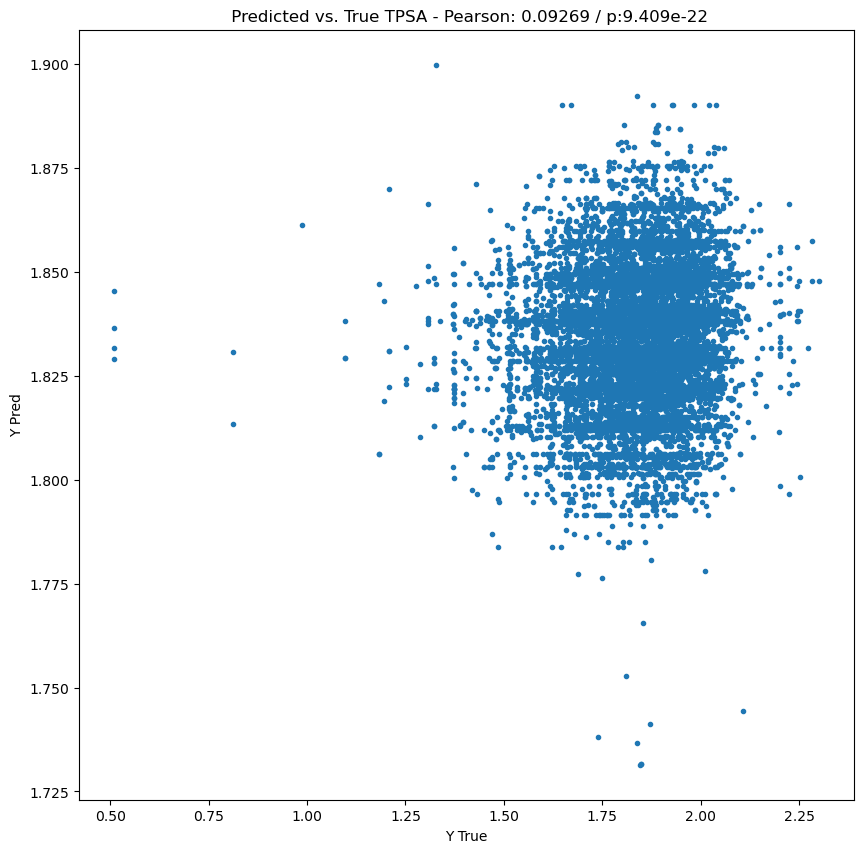

In [46]:
fig = plt.figure(figsize=(10,10))
plt.plot(y_test_np, y_pred, '.')
plt.title(f" Predicted vs. True TPSA - Pearson: {pearson_corr:.5f} / p:{pearson_p:.3e}")
plt.xlabel("Y True");
plt.ylabel("Y Pred");
# plt.xlim(1.775, 1.875)
# plt.xlim(1.775, 1.875)

Text(0.5, 0, 'TPSA Value')

Text(0, 0.5, 'Compounds')

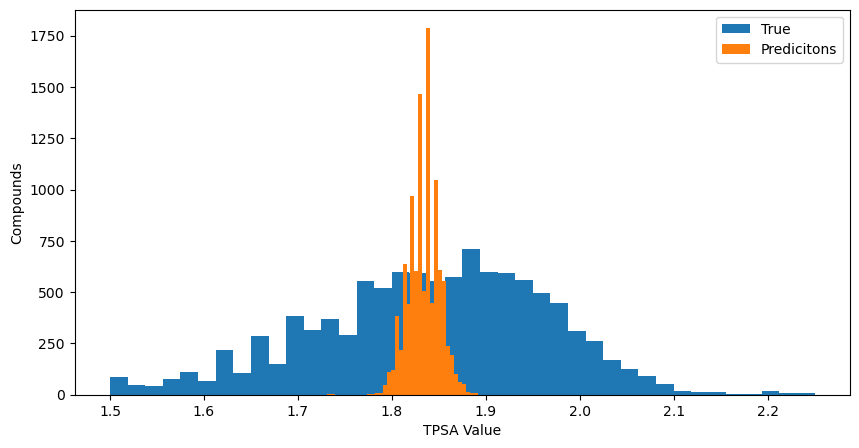

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 40
# fig, ax = plt.subplots()
 
# the histogram of the data

fig = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(y_test_np, num_bins, density=False, label = 'True', range=[1.5,2.25] )
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(y_pred, num_bins, density=False, label='Predicitons' )
plt.xlabel('TPSA Value')
plt.ylabel('Compounds')
plt.legend()
# ax.set_title('Histogram of normal distribution sample: '
#              fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$')
# axs[1].hist(dist2, bins=n_bins)

# XGBoost - Training using XGBoost native interface

### Plot importance 

In [ ]:
# train_score = xgb_reg.score(train_X, train_y)
# val_score = xgb_reg.score(val_X, val_y)
# test_score = xgb_reg.score(test_X, test_y)

In [ ]:
print(f" R2 score - Training   : {train_score:0.6f}")
print(f" R2 score - Validation : {val_score:0.6f}")
print(f" R2 score - Test data  : {test_score:0.6f}")

[Text(0, 0, 'f126'),
 Text(0, 1, 'f377'),
 Text(0, 2, 'f748'),
 Text(0, 3, 'f775'),
 Text(0, 4, 'f777'),
 Text(0, 5, 'f778'),
 Text(0, 6, 'f789'),
 Text(0, 7, 'f808'),
 Text(0, 8, 'f811'),
 Text(0, 9, 'f813'),
 Text(0, 10, 'f855'),
 Text(0, 11, 'f908'),
 Text(0, 12, 'f1012'),
 Text(0, 13, 'f1380'),
 Text(0, 14, 'f247')]

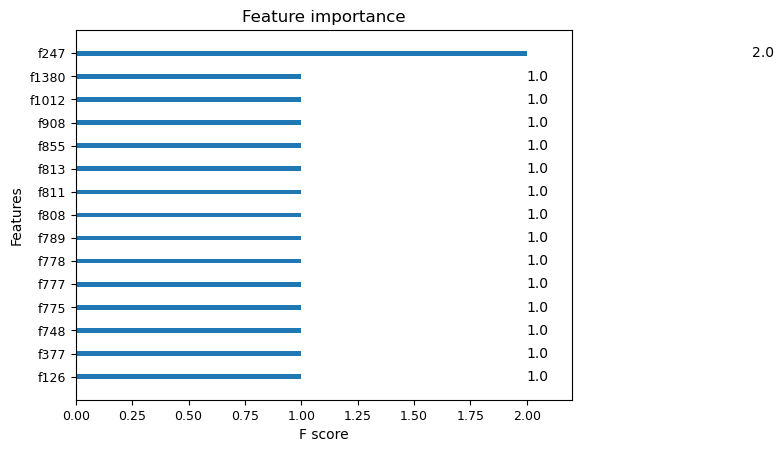

In [48]:
# fig = plt.figure(figsize=(20, 20))
# plt.yticks(fontsize = 12)
# ax = fig.add_subplot()
# ax.set_xlim(10,50)
ax = xgb.plot_importance(model_copy, max_num_features= None,  grid = False,  show_values = True, )
for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)

<Axes: >

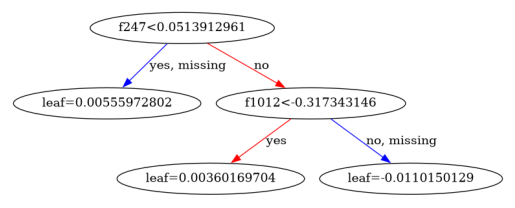

In [29]:
from graphviz import Source 
xgb.plot_tree(model_copy,num_tress=5)

In [30]:
# model_copy.attributes()
model_copy.feature_names
model_copy.

TypeError: Booster.get_split_value_histogram() missing 1 required positional argument: 'feature'

In [29]:
xgb.get_config()

{'use_rmm': False, 'verbosity': 1}

# XGBoost - TPSA (Regression)

## Training using XGBoost native interface

**`xgboost.train`** `(params, dtrain, num_boost_round=10, *, `
`evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, `
`evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)`

**Parameters** 

**param** `(Dic[str, Any])`  Booster params

**tree_method** string [default= auto] - The tree construction algorithm used in XGBoost. See description in the reference paper and Tree Methods. \
Choices: `auto, exact, approx, hist` - this is a combination of commonly used updaters. For other updaters like refresh, set the parameter updater directly.\
    `auto:` Same as the hist tree method.\
    `exact:` Exact greedy algorithm. Enumerates all split candidates.\
    `approx:` Approximate greedy algorithm using quantile sketch and gradient histogram.\
    `hist:` Faster histogram optimized approximate greedy algorithm.y algorithm.

**Returns:** Booster: a trained booster model

In [25]:
# del output, dtrain

In [ ]:
 
dtrain = xgb.dask.DaskDMatrix(client, train_X, train_y)

dval = xgb.dask.DaskDMatrix(client, val_X, val_y)

In [29]:
if __name__ == "__main__":
 
    # X and y must be Dask dataframes or arrays
    # num_obs = 1e5
    # num_features = 20
    # X = da.random.random(size=(num_obs, num_features), chunks=(1000, num_features))
    # y = da.random.random(size=(num_obs, 1), chunks=(1000, 1))
    # dtrain = xgb.dask.DaskDMatrix(client, X, y)
    # or
    # dtrain = xgb.dask.DaskQuantileDMatrix(client, X, y)
    
    early_stopping_rounds=20
    es = xgb.callback.EarlyStopping(rounds=early_stopping_rounds, save_best=True)
    
    output = xgb.dask.train(
        client,
        {"verbosity": 2, "tree_method": "hist", "objective": "reg:squarederror"},
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, "train"), (dval, "val")],
        # xgb_model= output['booster'],
        callbacks = [es],
    )

[22:28:59] task [xgboost.dask-0]:tcp://127.0.0.1:46179 got new rank 0
[22:28:59] task [xgboost.dask-1]:tcp://127.0.0.1:32855 got new rank 1
[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:29:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

[22:29:05] INFO: /home/conda/fee

[0]	train-rmse:0.94858	val-rmse:0.95017


2023-12-18 22:29:19,420 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:21,443 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[1]	train-rmse:0.67449	val-rmse:0.67623


2023-12-18 22:29:21,942 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:23,313 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:23,820 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:24,850 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[2]	train-rmse:0.48666	val-rmse:0.48878


2023-12-18 22:29:25,363 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:26,965 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[3]	train-rmse:0.36037	val-rmse:0.36298


2023-12-18 22:29:27,516 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:28,716 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:29,253 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:30,568 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:30,960 - distributed.utils_perf - WARNING - full 

[4]	train-rmse:0.27814	val-rmse:0.28137


2023-12-18 22:29:31,876 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:31,876 - distributed.worker.memory - WARNING - gc.collect() took 1.023s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
[22:29:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:32,613 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:33,965 - distributed.utils_perf - WARNING - full garbage collections took 27% CP

[5]	train-rmse:0.22697	val-rmse:0.23089


2023-12-18 22:29:37,062 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:37,916 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:39,032 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:39,686 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[6]	train-rmse:0.19701	val-rmse:0.20146


2023-12-18 22:29:40,744 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:41,432 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:42,737 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:43,376 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:44,411 - distributed.utils_perf - WARNING - full 

[7]	train-rmse:0.18028	val-rmse:0.18523


2023-12-18 22:29:46,097 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:46,366 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:46,367 - distributed.worker.memory - WARNING - gc.collect() took 1.141s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


[8]	train-rmse:0.17134	val-rmse:0.17663


2023-12-18 22:29:48,157 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:48,294 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:50,188 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:50,302 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboos

[9]	train-rmse:0.16661	val-rmse:0.17227


[22:29:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:52,285 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:52,414 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:53,375 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:53,375 - distributed.worker.memory - WARNING - gc.collect() took 1.082s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-12-18 22:29:54,113 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:54] INFO: /home/conda/feedstock_root/

[10]	train-rmse:0.16407	val-rmse:0.16999


2023-12-18 22:29:55,027 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
[22:29:55] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:29:56,004 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-18 22:29:56,843 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-12-18 22:29:57,019 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[11]	train-rmse:0.16274	val-rmse:0.16885


2023-12-18 22:29:57,649 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[12]	train-rmse:0.16181	val-rmse:0.16824


2023-12-18 22:29:59,641 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:29:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:29:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[13]	train-rmse:0.16120	val-rmse:0.16779


2023-12-18 22:30:01,654 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:30:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[14]	train-rmse:0.16065	val-rmse:0.16758


2023-12-18 22:30:03,538 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:30:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[15]	train-rmse:0.16027	val-rmse:0.16751


2023-12-18 22:30:05,521 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
[22:30:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:05,593 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[16]	train-rmse:0.15990	val-rmse:0.16746


[22:30:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:07,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[17]	train-rmse:0.15961	val-rmse:0.16738


[22:30:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[18]	train-rmse:0.15923	val-rmse:0.16735


[22:30:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[19]	train-rmse:0.15895	val-rmse:0.16730


[22:30:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[20]	train-rmse:0.15867	val-rmse:0.16734


[22:30:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[21]	train-rmse:0.15839	val-rmse:0.16734


[22:30:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[22]	train-rmse:0.15808	val-rmse:0.16730


[22:30:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[23]	train-rmse:0.15778	val-rmse:0.16724


[22:30:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[24]	train-rmse:0.15750	val-rmse:0.16724


[22:30:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[25]	train-rmse:0.15720	val-rmse:0.16716


2023-12-18 22:30:15,605 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:30:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[26]	train-rmse:0.15691	val-rmse:0.16711


[22:30:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:17,206 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[27]	train-rmse:0.15659	val-rmse:0.16707


[22:30:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[28]	train-rmse:0.15627	val-rmse:0.16696


[22:30:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[29]	train-rmse:0.15594	val-rmse:0.16694


[22:30:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[30]	train-rmse:0.15568	val-rmse:0.16696


[22:30:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[31]	train-rmse:0.15543	val-rmse:0.16691


[22:30:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[32]	train-rmse:0.15513	val-rmse:0.16685


[22:30:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[33]	train-rmse:0.15492	val-rmse:0.16683


[22:30:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[34]	train-rmse:0.15468	val-rmse:0.16684


[22:30:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:25,705 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[35]	train-rmse:0.15439	val-rmse:0.16683


[22:30:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:27,206 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[36]	train-rmse:0.15413	val-rmse:0.16679


[22:30:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[37]	train-rmse:0.15397	val-rmse:0.16678


[22:30:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[38]	train-rmse:0.15371	val-rmse:0.16672


[22:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[39]	train-rmse:0.15348	val-rmse:0.16674


[22:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[40]	train-rmse:0.15324	val-rmse:0.16670


[22:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:31] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[41]	train-rmse:0.15298	val-rmse:0.16666


[22:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[42]	train-rmse:0.15272	val-rmse:0.16665


[22:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[43]	train-rmse:0.15245	val-rmse:0.16660


[22:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[44]	train-rmse:0.15219	val-rmse:0.16656


2023-12-18 22:30:35,705 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:30:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[45]	train-rmse:0.15193	val-rmse:0.16655


[22:30:36] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:37,305 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[46]	train-rmse:0.15173	val-rmse:0.16652


[22:30:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[47]	train-rmse:0.15149	val-rmse:0.16650


[22:30:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[48]	train-rmse:0.15123	val-rmse:0.16648


[22:30:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[49]	train-rmse:0.15100	val-rmse:0.16649


[22:30:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[50]	train-rmse:0.15079	val-rmse:0.16648


[22:30:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[51]	train-rmse:0.15046	val-rmse:0.16647


[22:30:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[52]	train-rmse:0.15021	val-rmse:0.16645


[22:30:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[53]	train-rmse:0.14991	val-rmse:0.16638


[22:30:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[54]	train-rmse:0.14969	val-rmse:0.16637


[22:30:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:45,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[55]	train-rmse:0.14952	val-rmse:0.16638


[22:30:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[56]	train-rmse:0.14931	val-rmse:0.16639


[22:30:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:47,407 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[57]	train-rmse:0.14904	val-rmse:0.16634


[22:30:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[58]	train-rmse:0.14881	val-rmse:0.16631


[22:30:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[59]	train-rmse:0.14855	val-rmse:0.16627


[22:30:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[60]	train-rmse:0.14829	val-rmse:0.16626


[22:30:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[61]	train-rmse:0.14814	val-rmse:0.16626


[22:30:52] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:52] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[62]	train-rmse:0.14790	val-rmse:0.16622


[22:30:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[63]	train-rmse:0.14763	val-rmse:0.16621


[22:30:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[64]	train-rmse:0.14740	val-rmse:0.16616


2023-12-18 22:30:55,904 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[65]	train-rmse:0.14719	val-rmse:0.16616


[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:30:57,506 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[66]	train-rmse:0.14699	val-rmse:0.16616


[22:30:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[67]	train-rmse:0.14676	val-rmse:0.16614


[22:30:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:30:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[68]	train-rmse:0.14655	val-rmse:0.16617


[22:31:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[69]	train-rmse:0.14634	val-rmse:0.16620


[22:31:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[70]	train-rmse:0.14615	val-rmse:0.16623


[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[71]	train-rmse:0.14600	val-rmse:0.16623


[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[72]	train-rmse:0.14577	val-rmse:0.16625


[22:31:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[73]	train-rmse:0.14561	val-rmse:0.16624


[22:31:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[74]	train-rmse:0.14541	val-rmse:0.16622


2023-12-18 22:31:05,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:31:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[75]	train-rmse:0.14519	val-rmse:0.16620


[22:31:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

2023-12-18 22:31:07,606 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[76]	train-rmse:0.14493	val-rmse:0.16617


[22:31:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[77]	train-rmse:0.14474	val-rmse:0.16614


[22:31:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[78]	train-rmse:0.14454	val-rmse:0.16619


[22:31:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[79]	train-rmse:0.14428	val-rmse:0.16619


[22:31:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[80]	train-rmse:0.14409	val-rmse:0.16618


[22:31:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[81]	train-rmse:0.14390	val-rmse:0.16619


[22:31:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[82]	train-rmse:0.14366	val-rmse:0.16618


[22:31:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[83]	train-rmse:0.14347	val-rmse:0.16618


[22:31:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:16,004 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[84]	train-rmse:0.14325	val-rmse:0.16619


[22:31:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[85]	train-rmse:0.14305	val-rmse:0.16613


[22:31:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:17,706 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[86]	train-rmse:0.14287	val-rmse:0.16614


[22:31:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[87]	train-rmse:0.14265	val-rmse:0.16616


[22:31:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[88]	train-rmse:0.14242	val-rmse:0.16616


[22:31:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[89]	train-rmse:0.14219	val-rmse:0.16614


[22:31:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[90]	train-rmse:0.14195	val-rmse:0.16613


[22:31:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[91]	train-rmse:0.14183	val-rmse:0.16613


[22:31:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[92]	train-rmse:0.14161	val-rmse:0.16614


[22:31:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[93]	train-rmse:0.14141	val-rmse:0.16614


[22:31:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:26,005 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[94]	train-rmse:0.14124	val-rmse:0.16612


[22:31:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:26] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[95]	train-rmse:0.14104	val-rmse:0.16612


[22:31:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:27] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:27,805 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[96]	train-rmse:0.14086	val-rmse:0.16610


[22:31:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:28] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[97]	train-rmse:0.14068	val-rmse:0.16611


[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[98]	train-rmse:0.14054	val-rmse:0.16609


[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:29] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[99]	train-rmse:0.14033	val-rmse:0.16606


[22:31:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:30] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[100]	train-rmse:0.14012	val-rmse:0.16609


[22:31:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:32] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[101]	train-rmse:0.13990	val-rmse:0.16608


[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[102]	train-rmse:0.13977	val-rmse:0.16605


[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:33] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[103]	train-rmse:0.13956	val-rmse:0.16603


[22:31:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:34] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[104]	train-rmse:0.13941	val-rmse:0.16600


[22:31:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:35] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

2023-12-18 22:31:36,104 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[105]	train-rmse:0.13924	val-rmse:0.16597


[22:31:36] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:36] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[106]	train-rmse:0.13906	val-rmse:0.16598


[22:31:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:37] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:37,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[107]	train-rmse:0.13888	val-rmse:0.16600


[22:31:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:38] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[108]	train-rmse:0.13875	val-rmse:0.16598


[22:31:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:39] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[109]	train-rmse:0.13856	val-rmse:0.16598


[22:31:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:40] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[110]	train-rmse:0.13839	val-rmse:0.16597


[22:31:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:41] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[111]	train-rmse:0.13820	val-rmse:0.16593


[22:31:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:42] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[112]	train-rmse:0.13806	val-rmse:0.16594


[22:31:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:43] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[113]	train-rmse:0.13787	val-rmse:0.16596


[22:31:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:44] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[114]	train-rmse:0.13766	val-rmse:0.16594


[22:31:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[115]	train-rmse:0.13742	val-rmse:0.16590


[22:31:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:46,105 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[116]	train-rmse:0.13724	val-rmse:0.16590


[22:31:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:47] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:47,905 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[117]	train-rmse:0.13707	val-rmse:0.16587


[22:31:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:31:48] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[118]	train-rmse:0.13685	val-rmse:0.16586


[22:31:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:49] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[119]	train-rmse:0.13663	val-rmse:0.16585


[22:31:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:50] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[120]	train-rmse:0.13644	val-rmse:0.16587


[22:31:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:51] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[121]	train-rmse:0.13623	val-rmse:0.16586


[22:31:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:53] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[122]	train-rmse:0.13602	val-rmse:0.16584


[22:31:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:54] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[123]	train-rmse:0.13586	val-rmse:0.16582


[22:31:55] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:55] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:56,204 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[124]	train-rmse:0.13563	val-rmse:0.16585


[22:31:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:56] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[125]	train-rmse:0.13541	val-rmse:0.16584


[22:31:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:57] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:31:57,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[126]	train-rmse:0.13528	val-rmse:0.16584


[22:31:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:58] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[127]	train-rmse:0.13510	val-rmse:0.16584


[22:31:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:31:59] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[128]	train-rmse:0.13493	val-rmse:0.16581


[22:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[129]	train-rmse:0.13475	val-rmse:0.16580


[22:32:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:01] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[130]	train-rmse:0.13456	val-rmse:0.16578


[22:32:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:02] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[131]	train-rmse:0.13444	val-rmse:0.16577


[22:32:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:03] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[132]	train-rmse:0.13422	val-rmse:0.16579


[22:32:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:04] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[133]	train-rmse:0.13405	val-rmse:0.16575


[22:32:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:05] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[134]	train-rmse:0.13387	val-rmse:0.16576


2023-12-18 22:32:06,304 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB
[22:32:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:06] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[135]	train-rmse:0.13367	val-rmse:0.16582


[22:32:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:07] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:32:08,005 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[136]	train-rmse:0.13354	val-rmse:0.16581


[22:32:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:08] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[137]	train-rmse:0.13339	val-rmse:0.16583


[22:32:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:09] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[138]	train-rmse:0.13319	val-rmse:0.16584


[22:32:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:10] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[139]	train-rmse:0.13304	val-rmse:0.16584


[22:32:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:11] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[140]	train-rmse:0.13284	val-rmse:0.16580


[22:32:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:12] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[141]	train-rmse:0.13264	val-rmse:0.16581


[22:32:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:13] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[142]	train-rmse:0.13247	val-rmse:0.16581


[22:32:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[143]	train-rmse:0.13232	val-rmse:0.16583


[22:32:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:32:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.

2023-12-18 22:32:16,306 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.56 GiB -- Worker memory limit: 5.84 GiB


[144]	train-rmse:0.13214	val-rmse:0.16580


[22:32:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[145]	train-rmse:0.13194	val-rmse:0.16582


[22:32:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
2023-12-18 22:32:18,006 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.48 GiB -- Worker memory limit: 5.84 GiB


[146]	train-rmse:0.13174	val-rmse:0.16583


[22:32:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[147]	train-rmse:0.13157	val-rmse:0.16582


[22:32:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[148]	train-rmse:0.13139	val-rmse:0.16583


[22:32:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:32:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



[149]	train-rmse:0.13121	val-rmse:0.16583


[22:32:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:21] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[150]	train-rmse:0.13106	val-rmse:0.16582


[22:32:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:22] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[151]	train-rmse:0.13086	val-rmse:0.16583


[22:32:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:23] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


[152]	train-rmse:0.13069	val-rmse:0.16580


[22:32:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:24] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[22:32:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.[22:32:25] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/gbm/gbtree.cc:179: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.



In [32]:

type(output['booster'])
# output
output['booster'][133]
output['booster'].best_ntree_limit
# output['history']['train']['rmse']
# output['history']['val']['rmse']
# prev_history = output['history']



xgboost.core.Booster

134

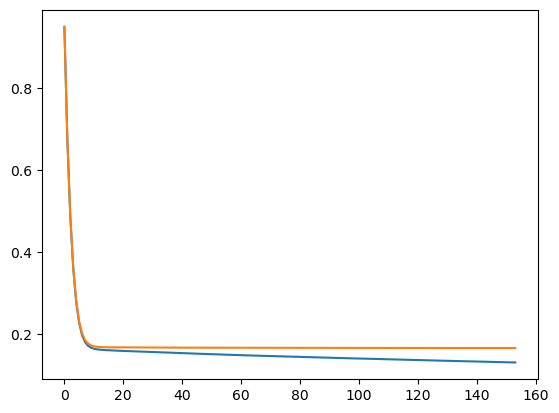

In [31]:
plt.plot(output['history']['train']['rmse']);
plt.plot(output['history']['val']['rmse']);

In [62]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

(10.0, 50.0)

[Text(0, 0, 'Cells_Intensity_MinIntensity_Mito'),
 Text(0, 1, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_6of20'),
 Text(0, 2, 'Cells_AreaShape_Zernike_7_3'),
 Text(0, 3, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_7of20'),
 Text(0, 4, 'Cytoplasm_Granularity_13_DNA'),
 Text(0, 5, 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_7of16'),
 Text(0, 6, 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_1of20'),
 Text(0, 7, 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20'),
 Text(0, 8, 'Nuclei_Children_Cytoplasm_Count'),
 Text(0, 9, 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_5of16'),
 Text(0, 10, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_6of16'),
 Text(0, 11, 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_5of20'),
 Text(0, 12, 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_6of16'),
 Text(0, 13, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_5of20'),
 Text(0, 14, 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_8of20'),

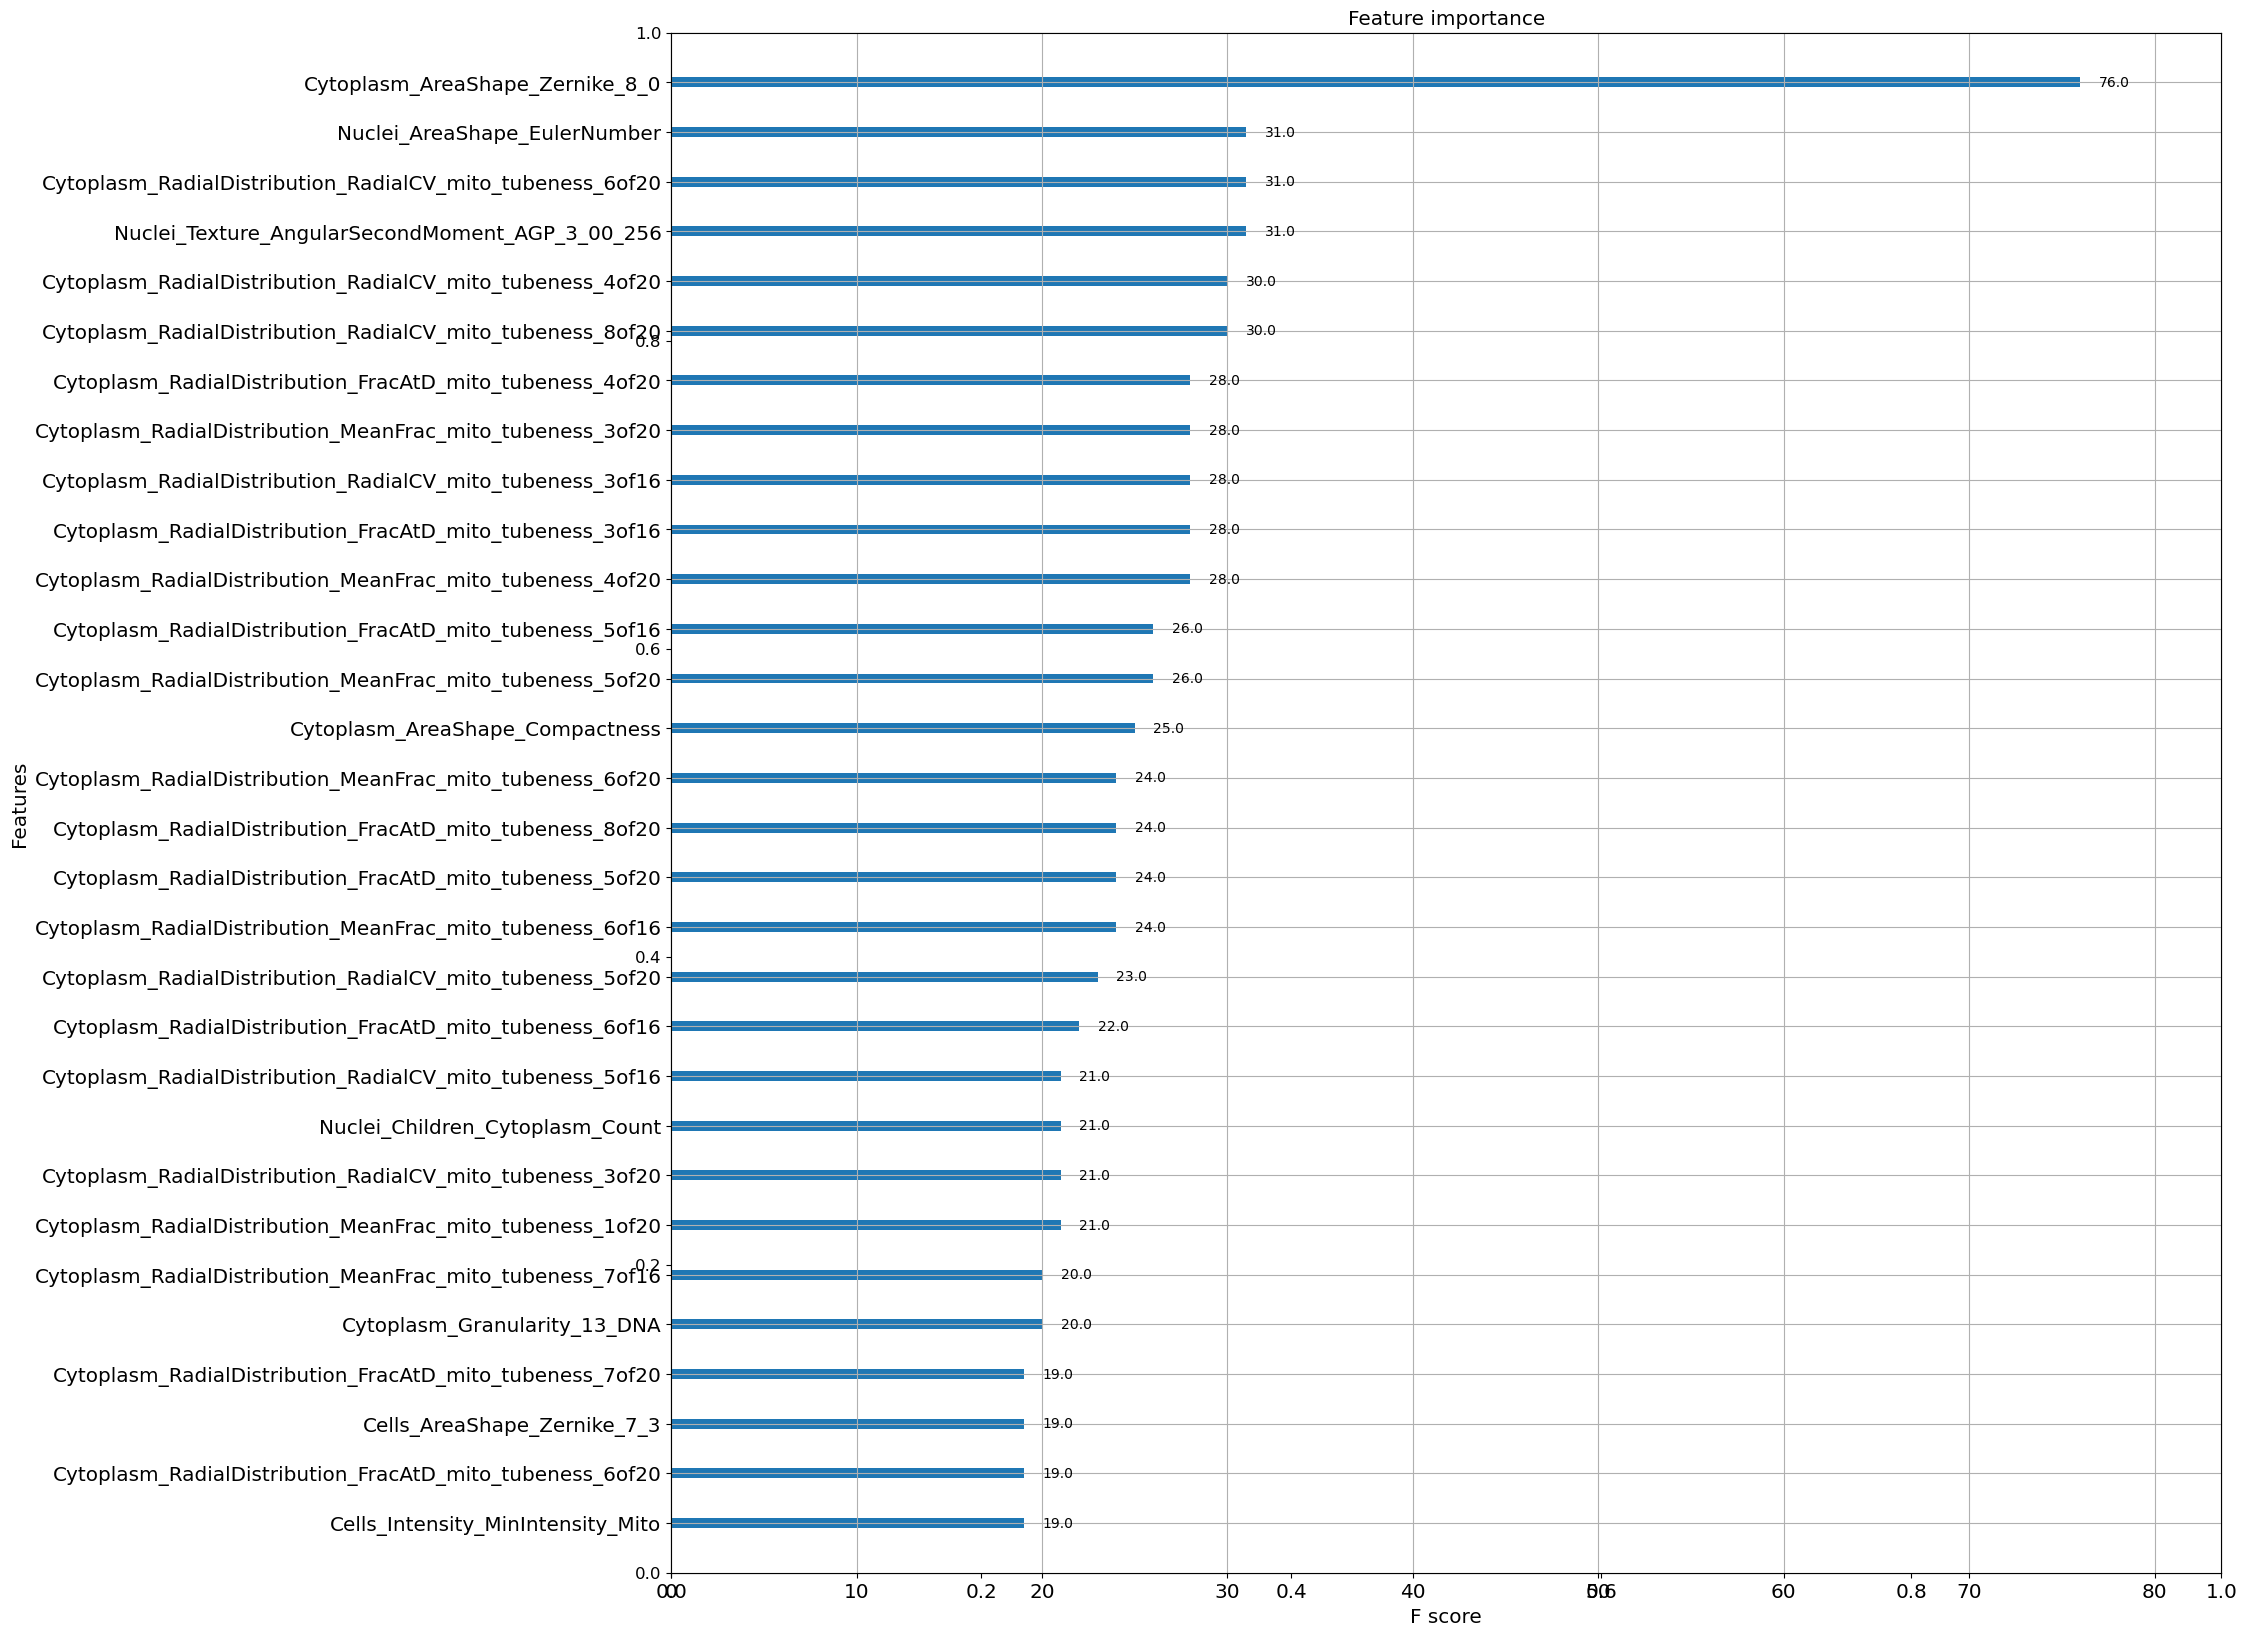

In [99]:
fig = plt.figure(figsize=(20, 20))
plt.yticks(fontsize = 12)
ax = fig.add_subplot()
ax.set_xlim(10,50)
ax = xgb.plot_importance(output['booster'], max_num_features= 30, ax = ax)
# for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(22)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)


In [101]:
output['booster'][133].save_model('./save_20231218_233500_model.json')

In [104]:
config = output['booster'][133].save_config()
type(config)
print(config)

str

{"learner":{"generic_param":{"fail_on_invalid_gpu_id":"0","gpu_id":"-1","n_jobs":"2","nthread":"2","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"1","size_leaf_vector":"0"},"gbtree_train_param":{"predictor":"auto","process_type":"default","tree_method":"hist","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"updater":{"grow_quantile_histmaker":{"train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0",

In [101]:
output['booster'][133].save_model('./save_20231218_233500_model.json')